Outlier Detection with DBSCAN

# DBSCAN Örnek

In [1]:
import numpy as np

from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler

Generate sample data

In [2]:
# Generate sample data
centers = [[1, 1], [-1, -1], [1, -1]]
X, labels_true = make_blobs(
    n_samples=750, centers=centers, cluster_std=0.4, random_state=0
)

In [3]:
X = StandardScaler().fit_transform(X)

DBSCAN algorithm will applied to generated data

In [4]:
# Compute DBSCAN
db = DBSCAN(eps=0.3, min_samples=10).fit(X)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print("Estimated number of clusters: %d" % n_clusters_)
print("Estimated number of noise points: %d" % n_noise_)
print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels_true, labels))
print("Completeness: %0.3f" % metrics.completeness_score(labels_true, labels))
print("V-measure: %0.3f" % metrics.v_measure_score(labels_true, labels))
print("Adjusted Rand Index: %0.3f" % metrics.adjusted_rand_score(labels_true, labels))
print(
    "Adjusted Mutual Information: %0.3f"
    % metrics.adjusted_mutual_info_score(labels_true, labels)
)
print("Silhouette Coefficient: %0.3f" % metrics.silhouette_score(X, labels))

Estimated number of clusters: 3
Estimated number of noise points: 18
Homogeneity: 0.953
Completeness: 0.883
V-measure: 0.917
Adjusted Rand Index: 0.952
Adjusted Mutual Information: 0.916
Silhouette Coefficient: 0.626


Plot algorithm result

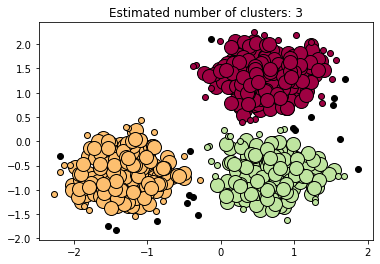

In [5]:
import matplotlib.pyplot as plt

# Black removed and is used for noise instead.
unique_labels = set(labels)
colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = labels == k

    xy = X[class_member_mask & core_samples_mask]
    plt.plot(
        xy[:, 0],
        xy[:, 1],
        "o",
        markerfacecolor=tuple(col),
        markeredgecolor="k",
        markersize=14,
    )

    xy = X[class_member_mask & ~core_samples_mask]
    plt.plot(
        xy[:, 0],
        xy[:, 1],
        "o",
        markerfacecolor=tuple(col),
        markeredgecolor="k",
        markersize=6,
    )

plt.title("Estimated number of clusters: %d" % n_clusters_)
plt.show()

## İşlem Adımları

1 - Veriyi indir (https://web.ais.dk/aisdata/)

2 - Veriyi Postgres'e aktar

3 - Geom sütunu oluştur

4 - Trip time determination

5 - Find Optimum Espilon Value

6 - Apply DBSCAN

7 - Export to CSV

## Connect to database

In [1]:
import psycopg2

try:
    conn = psycopg2.connect(database='trajectory',
                                user='postgres',
                                password='1234',
                                host='localhost',
                                port='5432')
    cur = conn.cursor()
    print("Connected to PostgreSQL Server")
except:
    print("Postgres connection failed!")

Connected to PostgreSQL Server


## Trip Time Determination

save to file

In [3]:
from datetime import timedelta

file = open("example.txt", "w")

sog_value=0.5
ship = 219005068

query = " select mmsi,time_info,sog " \
        " from ships_0910_geom s"\
        " FULL JOIN zones z1 ON ST_Dwithin(z1.geom, s.geom,0.003) "\
        " where mmsi={} and sog<{} "\
        " order by time_info desc ".format(ship,sog_value)
    
cur.execute(query)
    
rows = cur.fetchall()
before_time=""
i=0
threshold_time=timedelta(hours = 0, minutes = 20, seconds = 0)
for row in (rows):
    #indx = rows.index(row)
    if(before_time==""):
        before_time=row[1]
    else:
        result=before_time-row[1]
        if(result>threshold_time):
            i=i+1
            file.write(str(row[0])+" ") #mmsi
            file.write(str(i)+" ") #id 
            file.write(str(row[1])+" ") #time_start
            file.write(str(row[1]+result)+" ") #time_finish
            file.write(str(result)+" ") #duration
            file.write("\n") 
        before_time=row[1]

[(219005068, datetime.datetime(2021, 9, 10, 23, 59, 2), 0.0), (219005068, datetime.datetime(2021, 9, 10, 23, 58, 58), 0.0), (219005068, datetime.datetime(2021, 9, 10, 23, 55, 59), 0.0), (219005068, datetime.datetime(2021, 9, 10, 23, 52, 58), 0.0), (219005068, datetime.datetime(2021, 9, 10, 23, 49, 59), 0.0), (219005068, datetime.datetime(2021, 9, 10, 23, 46, 59), 0.0), (219005068, datetime.datetime(2021, 9, 10, 23, 46, 57), 0.0), (219005068, datetime.datetime(2021, 9, 10, 23, 43, 56), 0.0), (219005068, datetime.datetime(2021, 9, 10, 23, 40, 59), 0.0), (219005068, datetime.datetime(2021, 9, 10, 23, 40, 59), 0.0), (219005068, datetime.datetime(2021, 9, 10, 23, 37, 56), 0.0), (219005068, datetime.datetime(2021, 9, 10, 23, 35, 2), 0.0), (219005068, datetime.datetime(2021, 9, 10, 23, 34, 59), 0.0), (219005068, datetime.datetime(2021, 9, 10, 23, 31, 57), 0.0), (219005068, datetime.datetime(2021, 9, 10, 23, 29), 0.0), (219005068, datetime.datetime(2021, 9, 10, 23, 28, 59), 0.0), (219005068, d

## Find Optimum Epsilon Value

In [4]:
from turf.center import center

In [5]:
def getVesselSpecificTime(table_name,mmsi,start_time,finish_time):
    query =  "SELECT lon,lat "\
        "from {} "\
        "where mmsi='{}' and time_info>= '{}' and time_info<='{}' ".format(table_name,mmsi,start_time,finish_time)

    cur = conn.cursor()
    cur.execute(query)
    result=cur.fetchall()
    return result

In [6]:
def getVesselSpecificTimewithTimeInfo(table_name,mmsi,start_time,finish_time):
    query =  "SELECT lon,lat,time_info "\
        "from {} "\
        "where mmsi='{}' and time_info>= '{}' and time_info<='{}' ".format(table_name,mmsi,start_time,finish_time)

    cur = conn.cursor()
    cur.execute(query)
    result=cur.fetchall()
    return result

In [8]:
from datetime import datetime

table_name="ships_opt"
default_mmsi=219005068
time_range=timedelta(minutes=10)

analyse_points={} # points will be saved

f2 = open("example.txt", "r")
for x in f2:
    line=x.split()
    mmsi=line[0]
    if mmsi==str(default_mmsi):
        datee=line[2]
        datee=datee.split("-")
        start_time=line[3].split(":")
        start_time2=line[2]+" "+line[3]
        general_start_time_obj=datetime(int(datee[0]),int(datee[1]),int(datee[2]),int(start_time[0]),int(start_time[1]),int(start_time[2]))

        finish_time=line[5].split(":")
        finish_time2=line[4]+" "+line[5]
        finish_epoch=datetime(int(datee[0]),int(datee[1]),int(datee[2]),int(finish_time[0]),int(finish_time[1]),int(finish_time[2]))
        epoch1=datetime(int(datee[0]),int(datee[1]),int(datee[2]),int(start_time[0]),int(start_time[1]),int(start_time[2]))
        epoch2=epoch1+time_range

        count=0
        while True:
            print("--------------------")
            print(epoch1)
            print(epoch2)
            # get points 
            points=getVesselSpecificTime(table_name,mmsi,epoch1,epoch2)
            points_info=getVesselSpecificTimewithTimeInfo(table_name,mmsi,epoch1,epoch2)
            
            if("info"+str(count+1) in analyse_points):
                analyse_points["info"+str(count+1)]=analyse_points["info"+str(count+1)]+points_info
            else:
                analyse_points["info"+str(count+1)]=points_info

            if(str(count+1) in analyse_points):
                analyse_points[str(count+1)]=analyse_points[str(count+1)]+points
            else:
                analyse_points[str(count+1)]=points

            epoch1=epoch2
            epoch2=epoch1+time_range
            if(epoch1>finish_epoch):
                break
            else:
                count=count+1

--------------------
2021-09-10 19:01:37
2021-09-10 19:11:37
--------------------
2021-09-10 19:11:37
2021-09-10 19:21:37
--------------------
2021-09-10 19:21:37
2021-09-10 19:31:37
--------------------
2021-09-10 19:31:37
2021-09-10 19:41:37
--------------------
2021-09-10 19:41:37
2021-09-10 19:51:37
--------------------
2021-09-10 18:02:07
2021-09-10 18:12:07
--------------------
2021-09-10 18:12:07
2021-09-10 18:22:07
--------------------
2021-09-10 18:22:07
2021-09-10 18:32:07
--------------------
2021-09-10 18:32:07
2021-09-10 18:42:07
--------------------
2021-09-10 18:42:07
2021-09-10 18:52:07
--------------------
2021-09-10 17:03:16
2021-09-10 17:13:16
--------------------
2021-09-10 17:13:16
2021-09-10 17:23:16
--------------------
2021-09-10 17:23:16
2021-09-10 17:33:16
--------------------
2021-09-10 17:33:16
2021-09-10 17:43:16
--------------------
2021-09-10 17:43:16
2021-09-10 17:53:16
--------------------
2021-09-10 16:01:07
2021-09-10 16:11:07
--------------------
202

In [13]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN

# cluster Points with dbscan
def clusterPoints(points,epsilon,min_samples):
    X = StandardScaler().fit_transform(points)
    clustering = DBSCAN(eps=epsilon, min_samples=min_samples).fit(X)
    return clustering.labels_

In [16]:
graph_x=[]
graph_y=[]
eps = 1
while True:
    analyse_number=0
    possible_outliers=0
    while True:
        if(str(analyse_number+1) in analyse_points):
            # cluster
                cluster_result=clusterPoints(analyse_points[str(analyse_number+1)],eps,8)
                for out in range(len(cluster_result)):
                    if cluster_result[out]==-1:
                        possible_outliers=possible_outliers+1
                analyse_number=analyse_number+1
        else:
            break


    print(possible_outliers)
    graph_y.append(possible_outliers)
    graph_x.append(eps)
    eps=eps-0.02
    print(eps)
    if(eps<0):
        break

0
0.98
0
0.96
0
0.94
0
0.9199999999999999
0
0.8999999999999999
0
0.8799999999999999
0
0.8599999999999999
0
0.8399999999999999
0
0.8199999999999998
0
0.7999999999999998
0
0.7799999999999998
0
0.7599999999999998
0
0.7399999999999998
0
0.7199999999999998
0
0.6999999999999997
0
0.6799999999999997
0
0.6599999999999997
0
0.6399999999999997
0
0.6199999999999997
0
0.5999999999999996
0
0.5799999999999996
0
0.5599999999999996
0
0.5399999999999996
0
0.5199999999999996
0
0.49999999999999956
0
0.47999999999999954
0
0.4599999999999995
0
0.4399999999999995
0
0.4199999999999995
0
0.39999999999999947
0
0.37999999999999945
0
0.35999999999999943
0
0.3399999999999994
6
0.3199999999999994
9
0.2999999999999994
9
0.27999999999999936
10
0.25999999999999934
10
0.23999999999999935
11
0.21999999999999936
12
0.19999999999999937
14
0.17999999999999938
14
0.1599999999999994
16
0.1399999999999994
18
0.1199999999999994
20
0.0999999999999994
44
0.07999999999999939
61
0.05999999999999939
138
0.03999999999999938
244
0.0

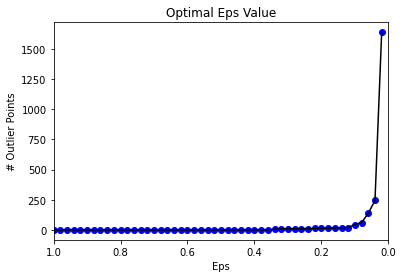

In [17]:
import numpy as np
import matplotlib.pyplot as plt

np_graph_x = np.asarray(graph_x, dtype=np.float32)
np_graph_y = np.asarray(graph_y, dtype=np.float32)

plt.xlim(max(np_graph_x), 0)

plt.xlabel('Eps')
plt.ylabel('# Outlier Points')
plt.title('Optimal Eps Value')
plt.plot(np_graph_x, np_graph_y, 'bo', np_graph_x, np_graph_y, 'k')
#plt.plot(np_graph_x, np_graph_y)
plt.show()

## Apply DBSCAN

In [21]:
def findinterval(time,file):
        f2 = open(file, "r")
        for x in f2:
            line=x.split()
            mmsi=line[0]
            tripId=line[1]

            datee=line[2]
            datee=datee.split("-")
            start_time=line[3].split(":")
            start_time2=line[2]+" "+line[3]
            general_start_time_obj=datetime(int(datee[0]),int(datee[1]),int(datee[2]),int(start_time[0]),int(start_time[1]),int(start_time[2]))

            finish_time=line[5].split(":")
            finish_time2=line[4]+" "+line[5]
            finish_epoch=datetime(int(datee[0]),int(datee[1]),int(datee[2]),int(finish_time[0]),int(finish_time[1]),int(finish_time[2]))

            if(time>=general_start_time_obj and time<=finish_epoch):
                return tripId
        return False

In [25]:
analyse_number=0
possible_outliers=[]
input_txt_file="example.txt"

while True:
    if(str(analyse_number+1) in analyse_points):
        # cluster
            cluster_result=clusterPoints(analyse_points[str(analyse_number+1)],0.08,8)
            #print(cluster_result)
            for out in range(len(cluster_result)):
                if cluster_result[out]==-1:
                    #print(analyse_points["info"+str(analyse_number+1)][out][2])
                    tripId=findinterval(analyse_points["info"+str(analyse_number+1)][out][2],input_txt_file)
                    if(tripId!=False):
                        possible_outliers.append(dict({"part":analyse_number+1,"point":analyse_points["info"+str(analyse_number+1)][out],"tripId":str(tripId)}))
            analyse_number=analyse_number+1
    else:
        break
print(len(possible_outliers))

61


In [27]:
import csv

with open('example.csv', mode='w') as csv_file:
    possible_outlers_fieldnames = ['part','tripId','time', 'lat', 'lon']
    writer = csv.DictWriter(csv_file, fieldnames=possible_outlers_fieldnames)
    writer.writeheader()
    for poss_outlier in possible_outliers:
        writer.writerow({'part':poss_outlier["part"],'tripId':poss_outlier["tripId"],'time': poss_outlier["point"][2],'lat':poss_outlier["point"][1],'lon':poss_outlier["point"][0] })